In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
import time
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1")
height, width = hub.get_expected_image_size(module)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [4]:
print("height: {0}, width: {1}".format(height, width))

height: 224, width: 224


In [6]:
car_image_files = glob.glob("drive/My Drive/xylosai/tensorflow/images/car/*.jpg")
len(car_image_files)

119

# With Dataset pipeline API

In [0]:
from tensorflow.data import Dataset

In [0]:
def _parse_function(filename):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize_images(image_decoded, [height, width])
  return image_resized

In [0]:
dataset = Dataset.from_tensor_slices(car_image_files[0:10]).map(_parse_function).map(lambda x: tf.div(x,255)).map(lambda x: tf.expand_dims(x, axis=0))

In [37]:
dataset.output_shapes

TensorShape([Dimension(1), Dimension(224), Dimension(224), Dimension(3)])

In [0]:
iterator = dataset.make_one_shot_iterator()

In [47]:
start_time = time.time()
with tf.device('/cpu:0'):
  next_image = iterator.get_next()
  for i in range(10):
    try:
      print("image {0}".format(i))
      print(module(next_image))

    except (tf.errors.OutOfRangeError, KeyboardInterrupt):
      break
      
duration = time.time() - start_time
print("Inference took {0} seconds".format(duration))

image 0
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default_101/hub_output/feature_vector/SpatialSqueeze:0", shape=(1, 2048), dtype=float32, device=/device:CPU:0)
image 1
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default_102/hub_output/feature_vector/SpatialSqueeze:0", shape=(1, 2048), dtype=float32, device=/device:CPU:0)
image 2
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default_103/hub_output/feature_vector/SpatialSqueeze:0", shape=(1, 2048), dtype=float32, device=/device:CPU:0)
image 3
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("module_apply_default_104/hub_output/feature_vector/SpatialSqueeze:0", shape=(1, 2048), dtype=float32, device=/device:CPU:0)
image 4
INFO:tensorflow:Saver not created because there are no variables in the grap

# With Numpy Array

Reading images plus inference takes longer this way. 

Comparison between CPU and GPU should be fairer this way, because time of loading and processing image is not included in comparison, only the inference itself. EDIT: comparison did not work...

In [0]:
image_array = np.expand_dims(cv2.resize(cv2.imread(car_image_files[0]),(height,width)),axis=0)
for file in car_image_files[1:]:
  image = np.expand_dims(cv2.resize(cv2.imread(file),(height,width)),axis=0)
  image_array = np.append(image_array,image,axis=0)

In [61]:
start_time = time.time()

with tf.device('/cpu:0'): #no difference observed with "/gpu:0", this device placement probably has no effect on inference with tensorflow hub module.
  features = module(image_array)
duration = time.time() - start_time
print("Inference took {0} seconds".format(duration))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Inference took 12.406121730804443 seconds


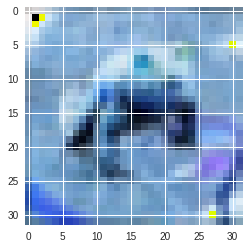

In [26]:
example_image = x_train[0,:]*255
plt.imshow(example_image)